git # Preprocessing

### Preperation
Import libraries and create the pandas dataframe

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import scipy.io.wavfile

energy_df = pd.read_csv('data/energy_dataset.csv')
energy_df['time'] = pd.to_datetime(energy_df['time'])
preprocessed_energy_df = energy_df.copy()

C:\Users\samwa\AppData\Local\Temp\ipykernel_1412\3197187471.py:8: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  energy_df['time'] = pd.to_datetime(energy_df['time'])


### Remove empty columns

In [2]:
preprocessed_energy_df = preprocessed_energy_df.loc[:, (preprocessed_energy_df.fillna(0) != 0).any(axis=0)]
column_names = preprocessed_energy_df.columns

### Fill in missing datapoints

In [3]:
preprocessed_energy_df = preprocessed_energy_df.interpolate(method='linear')

C:\Users\samwa\AppData\Local\Temp\ipykernel_1412\4152634649.py:1: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  preprocessed_energy_df = preprocessed_energy_df.interpolate(method='linear')


### Drop duplicate datapoints

In [4]:
preprocessed_energy_df = preprocessed_energy_df.drop_duplicates()

### Outlier detection

In [5]:
window_percentage = 3

# Function to get the upper and lower bands
def get_bands(data):
        upper_band = np.mean(data) + (3 * np.std(data))
        lower_band = np.mean(data) - (3 * np.std(data))
        return upper_band, lower_band

anomaly_masks = {}
for column_name in column_names[1:]:
    column = preprocessed_energy_df[column_name]
    N = len(column)
    k = int(N * (window_percentage/2/100))

    # Calculate the bands for each data point
    bands = [get_bands(column[max(0, i-k):min(i+k, N)]) for i in range(N)]
    upper, lower = zip(*bands)

    # Identify the anomalies
    anomalies = (column > upper) | (column < lower)
    anomaly_masks[column_name] = anomalies

# Combine anomaly masks using bitwise OR (|) for each column's mask
combined_mask = np.column_stack(list(anomaly_masks.values())).any(axis=1)

# Filter the data
preprocessed_energy_df = preprocessed_energy_df[~combined_mask]


### Low pass filter

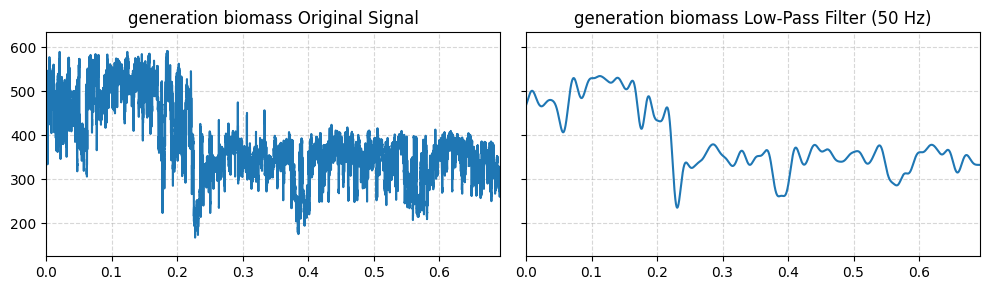

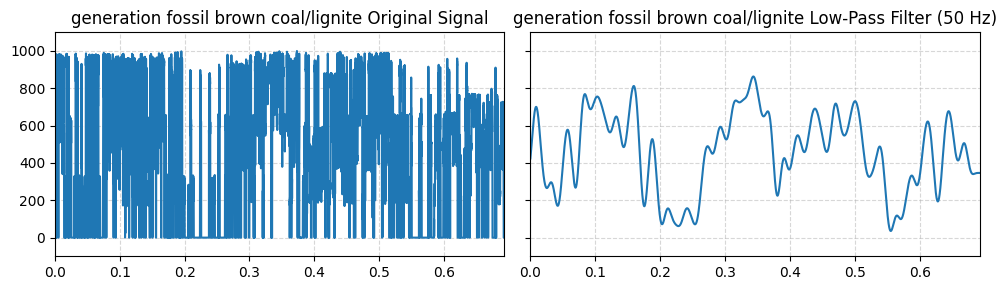

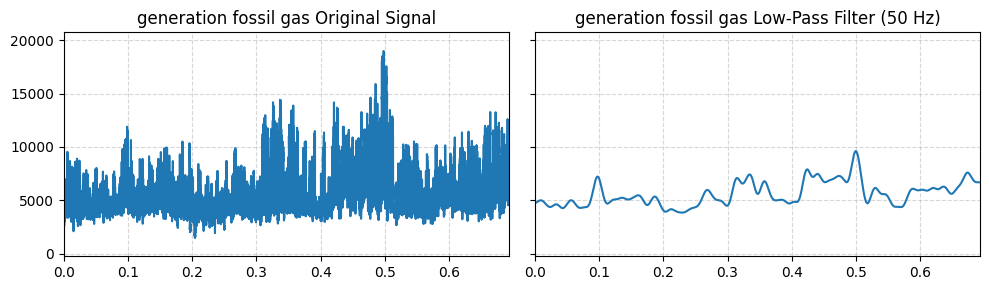

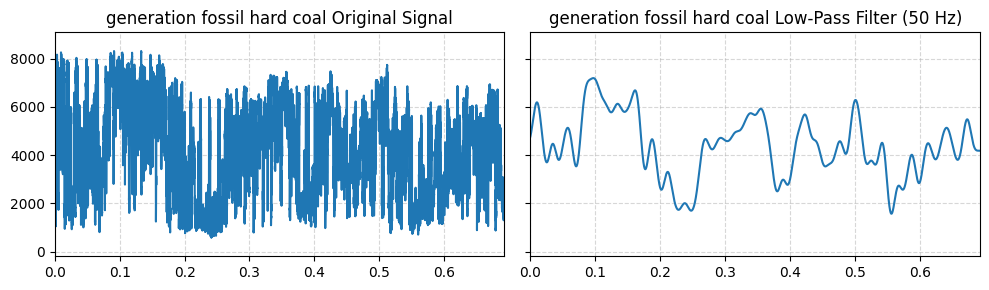

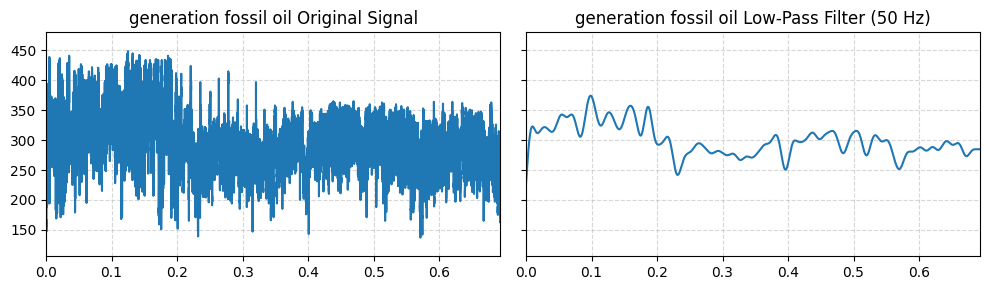

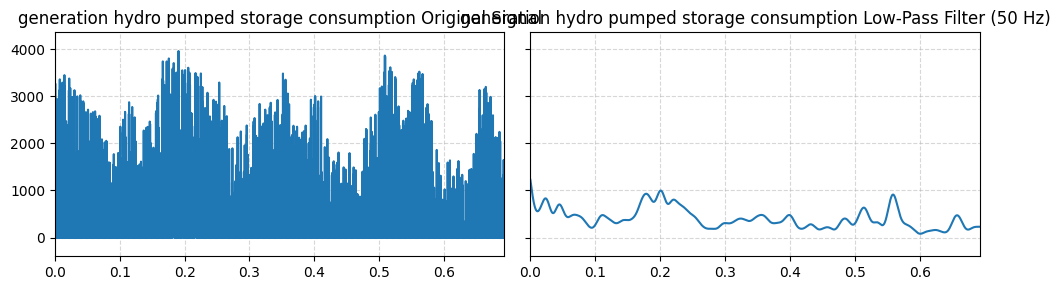

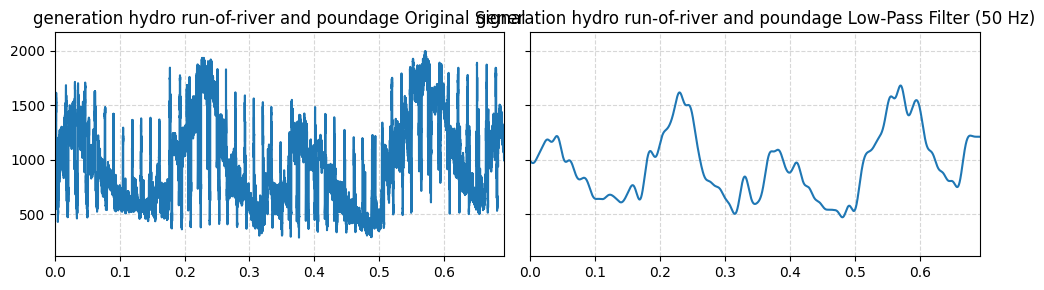

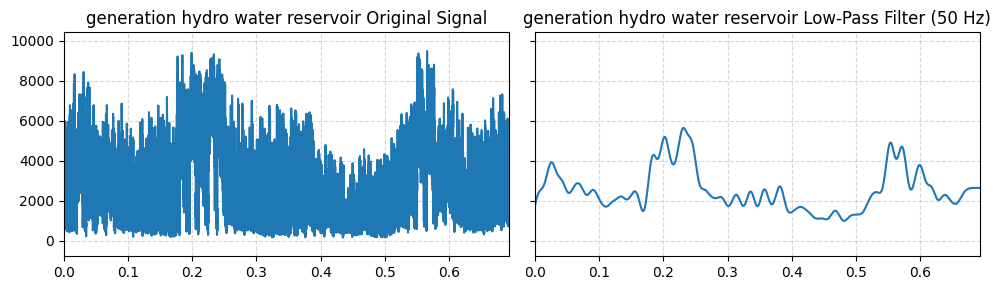

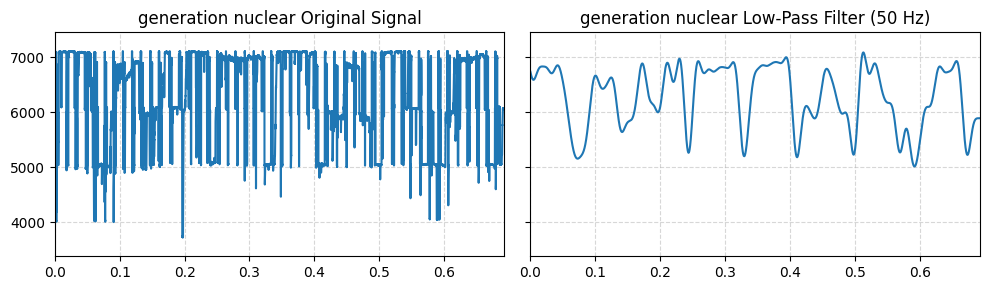

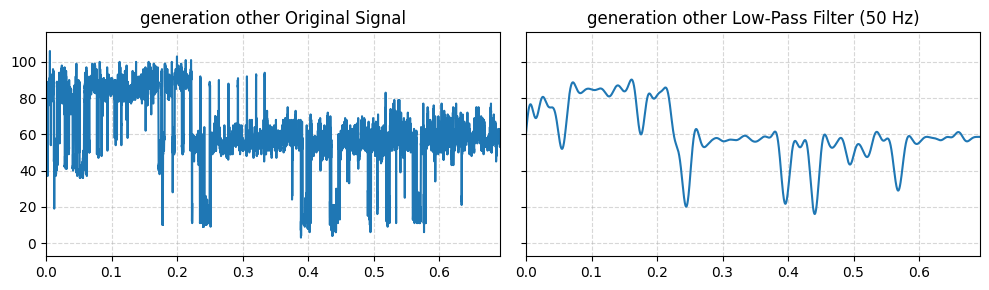

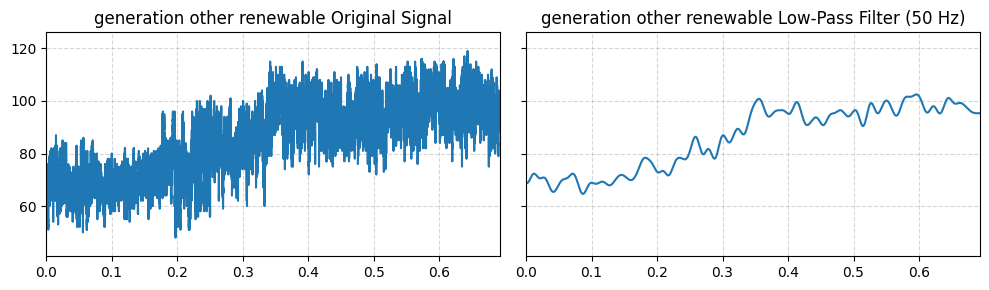

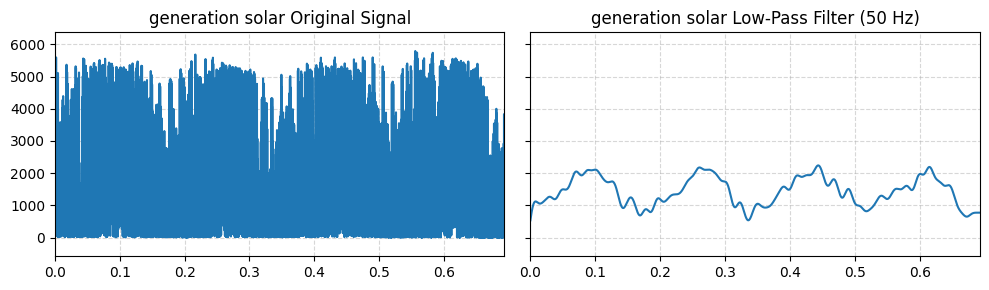

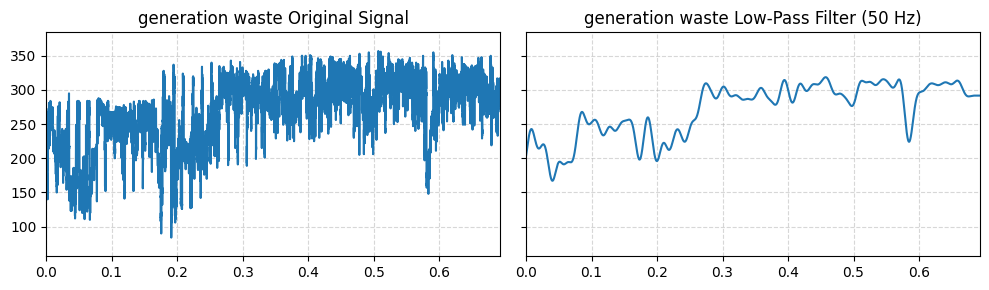

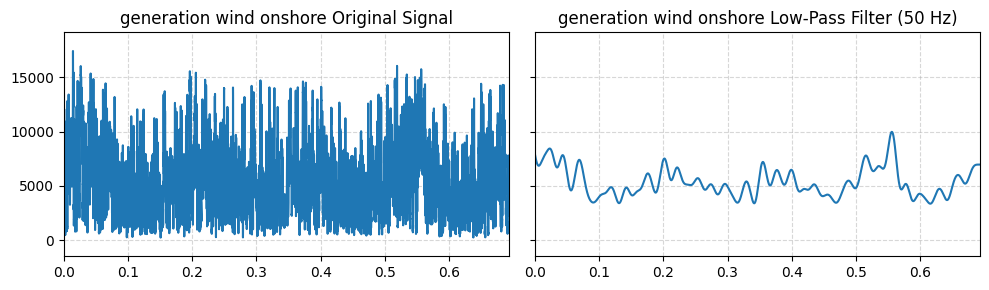

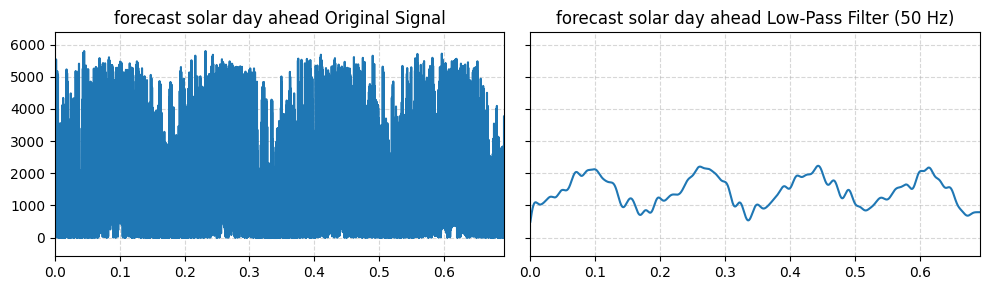

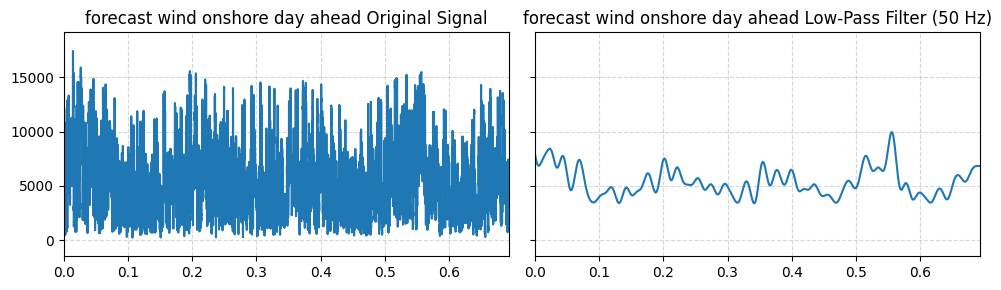

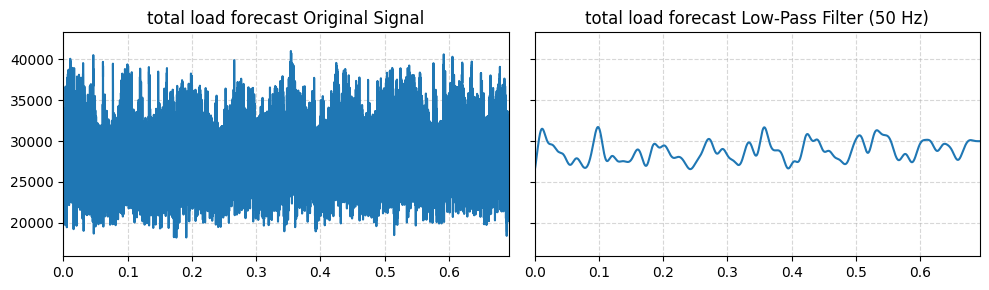

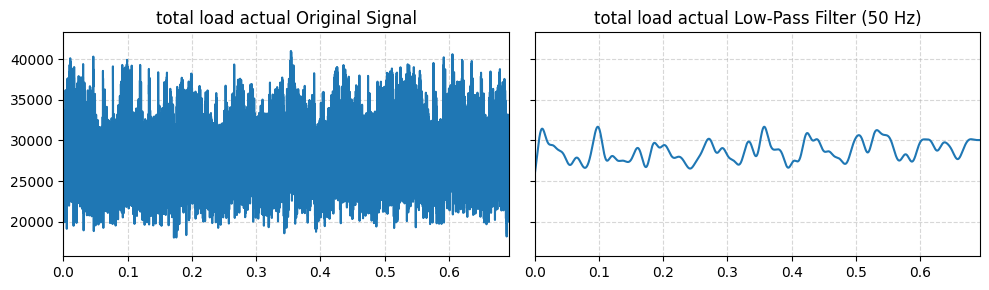

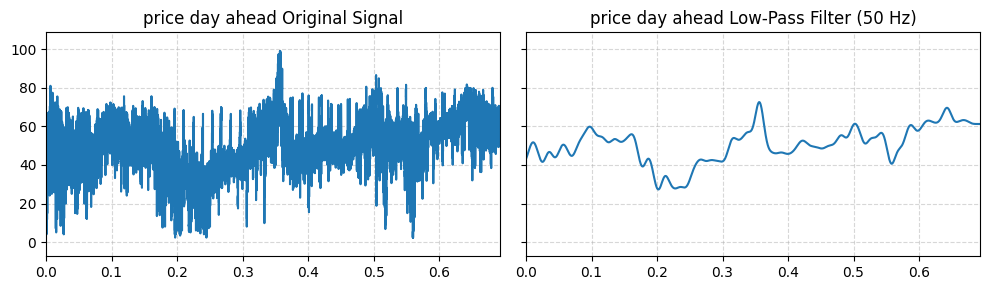

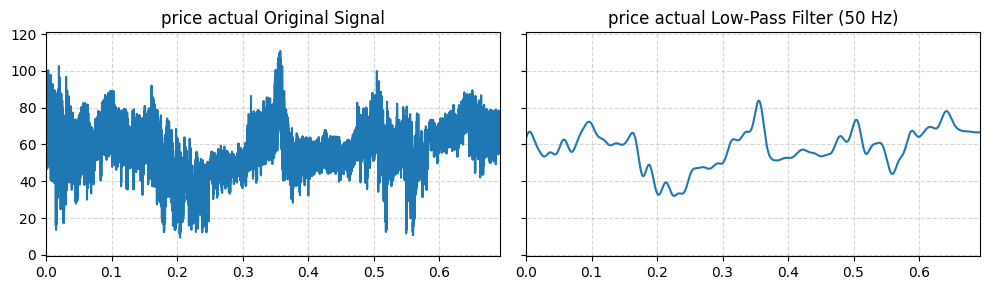

In [6]:
def lowpass(data: np.ndarray, cutoff: float, sample_rate: float, poles: int = 5):
    sos = scipy.signal.butter(poles, cutoff, 'lowpass', fs=sample_rate, output='sos')
    filtered_data = scipy.signal.sosfiltfilt(sos, data)
    return filtered_data

sample_rate = 44100
energy_df_trends = pd.DataFrame()
energy_df_trends['time'] = preprocessed_energy_df['time']

for column_name in column_names[1:]:
    data = preprocessed_energy_df[column_name].to_numpy()
    times = np.arange(len(data))/sample_rate
    
    trend = lowpass(data, 50, sample_rate)
    energy_df_trends[column_name] = trend
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3), sharex=True, sharey=True)
    ax1.plot(times, data)
    ax1.set_title(column_name + " Original Signal")
    ax1.margins(0, .1)
    ax1.grid(alpha=.5, ls='--')
    ax2.plot(times, trend)
    ax2.set_title(column_name + " Low-Pass Filter (50 Hz)")
    ax2.grid(alpha=.5, ls='--')
    plt.tight_layout()
    plt.show()

### Plot data

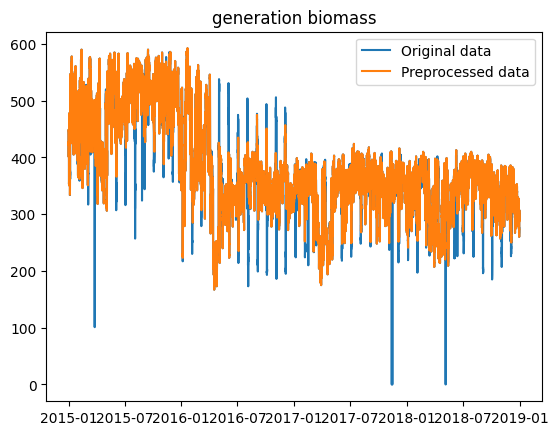

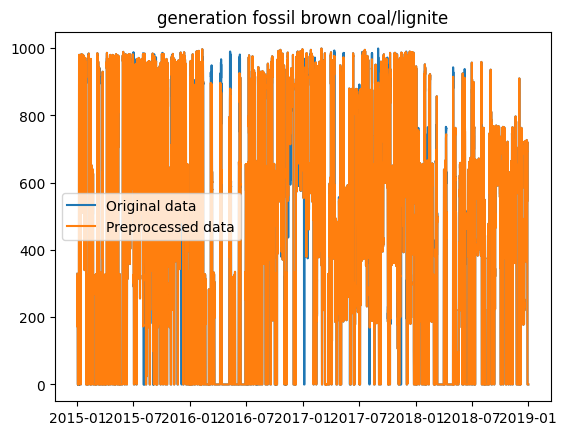

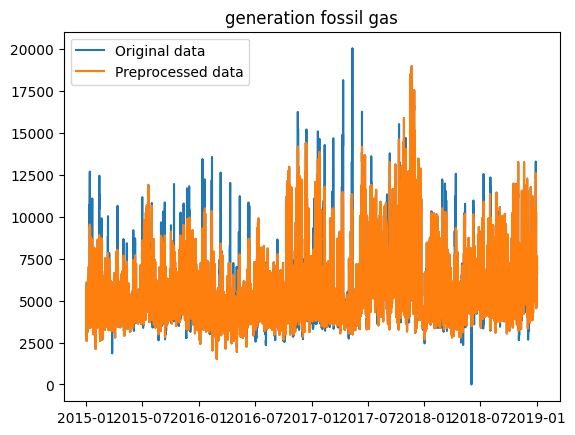

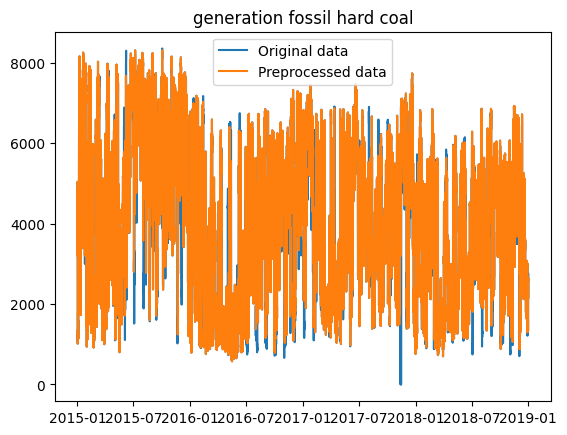

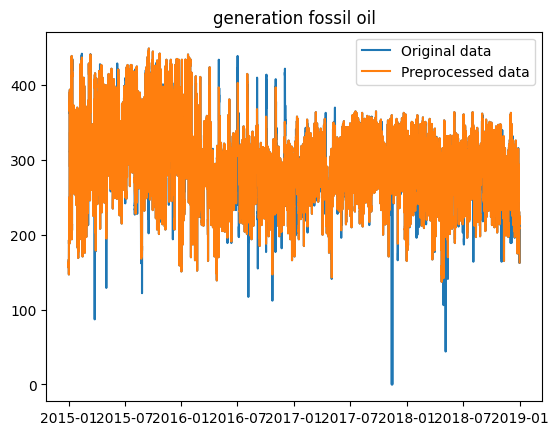

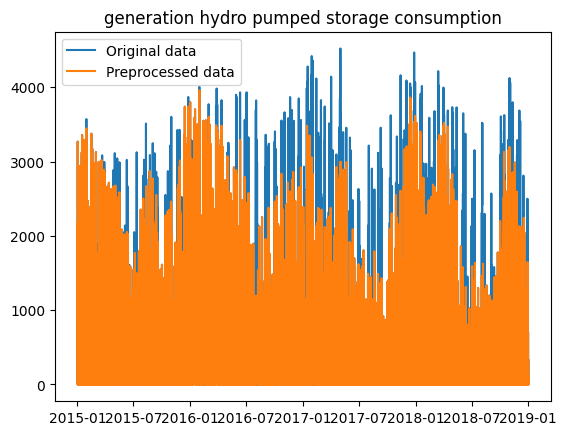

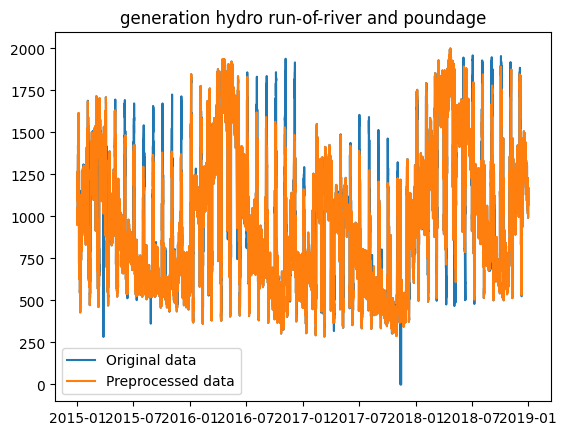

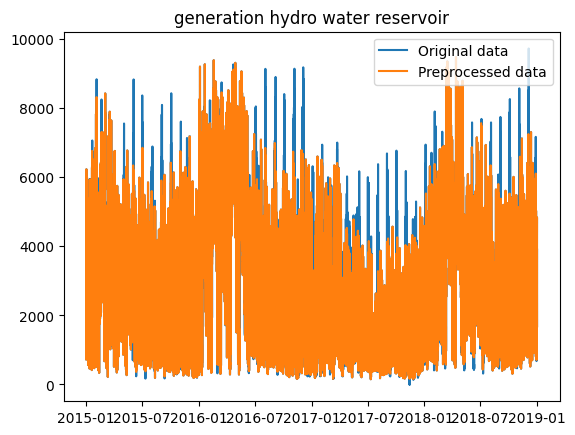

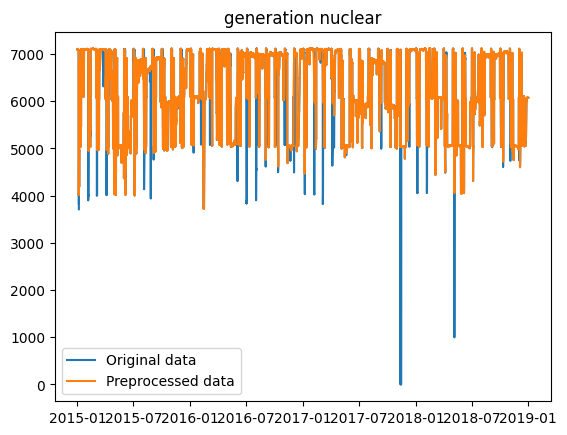

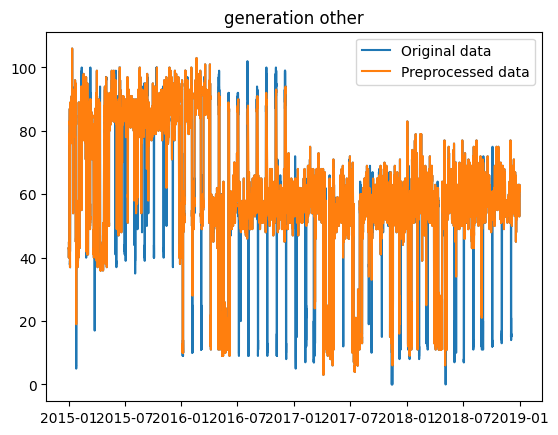

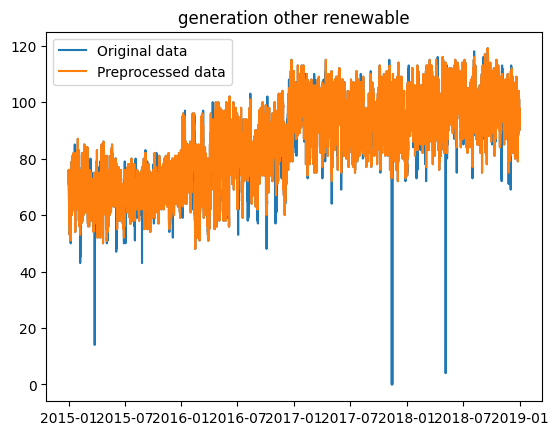

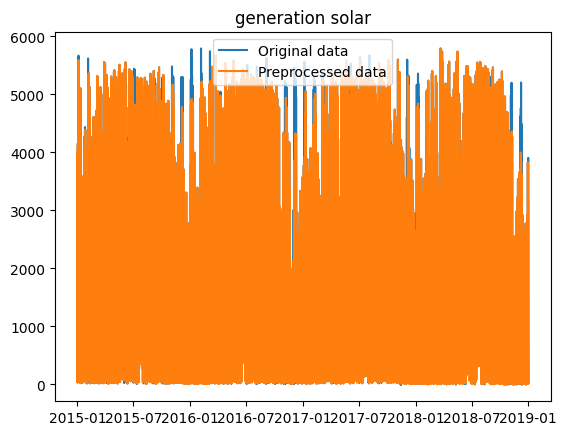

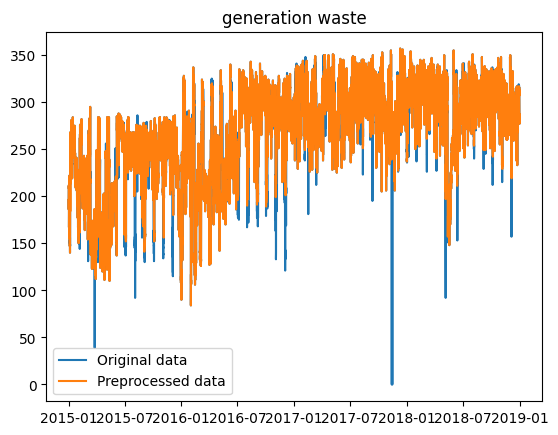

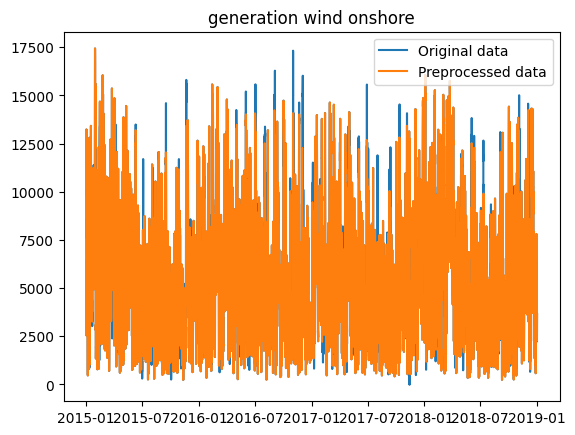

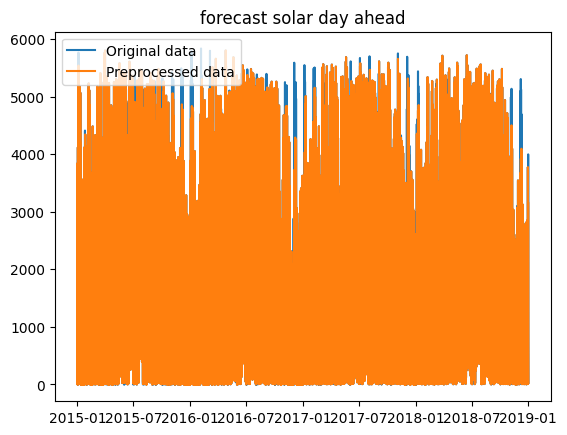

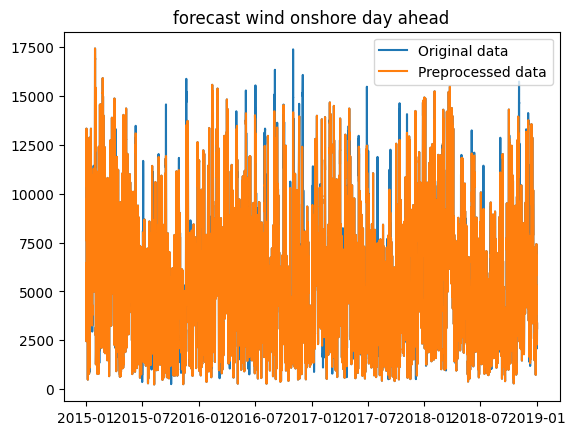

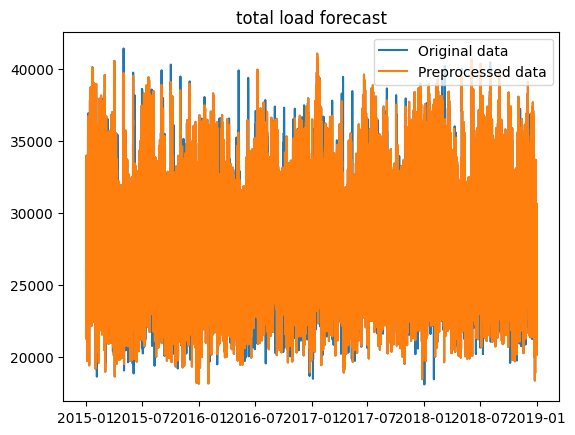

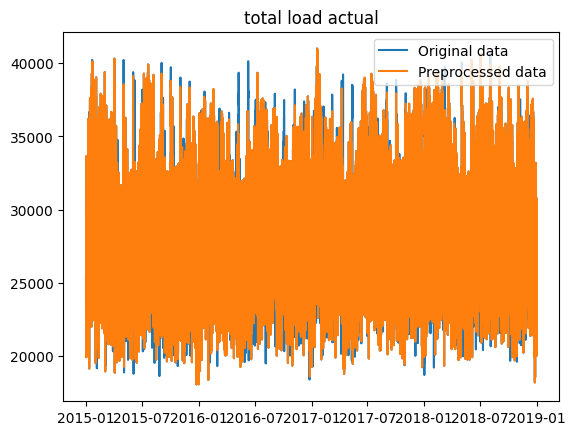

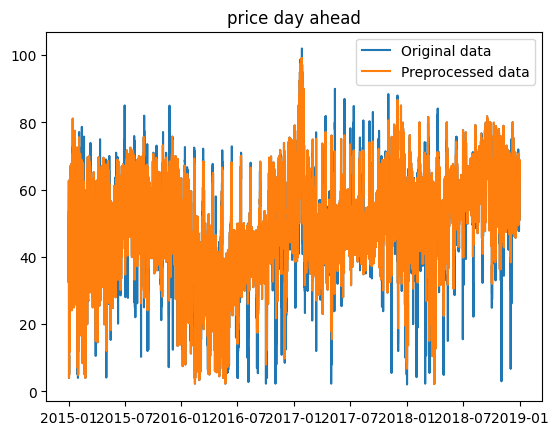

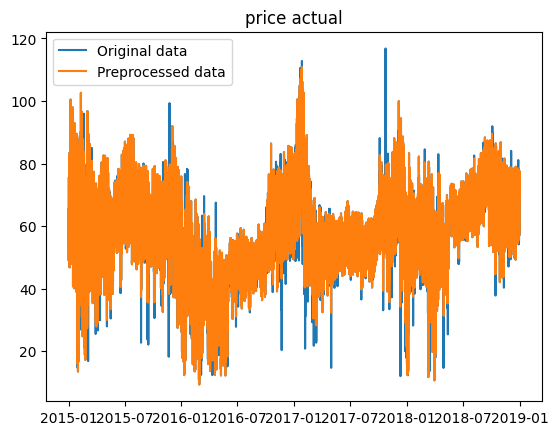

In [7]:
for column_name in column_names[1:]:
    plt.plot(energy_df['time'], energy_df[column_name], label='Original data')
    plt.plot(preprocessed_energy_df['time'], preprocessed_energy_df[column_name], label='Preprocessed data')
    plt.title(column_name)
    plt.legend()
    plt.show()

### Save to CSV

In [8]:
preprocessed_energy_df.to_csv('data/preprocessed_energy_dataset.csv', index=False)
energy_df_trends.to_csv('data/energy_dataset_trends.csv', index=False)